In [2]:
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt

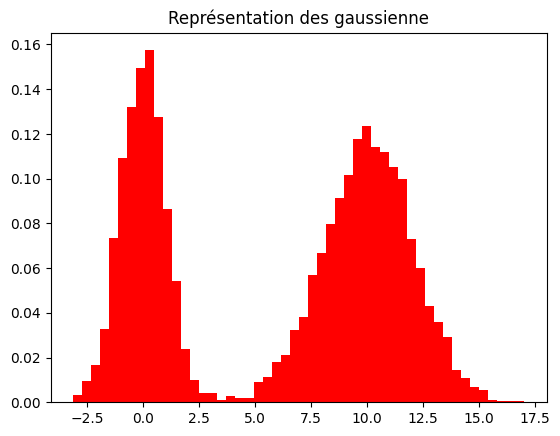

In [3]:
N=5000
p=[0.4,0.6]
mu=[0, 10]
Sigma=[1, 4] # attention : c'est la liste des VARIANCES des gaussiennes (et pas des ECART TYPES), car par convention on écrit les matrices de covariance en multidimensionnel

def minimum(p,u):
  if u<=p[0]:
    return 1
  return 2

U=np.random.uniform(0,1,N)
X=np.zeros(N)
for k in range(N):
  j=minimum(p,U[k])
  X[k]=np.random.normal(mu[j-1],np.sqrt(Sigma[j-1]))   # np.random.normal prend en argument l'ECART TYPE (et pas la VARIANCE, contrairement à multivariate_normal)

plt.hist(X, bins=50, density=True, color='red')
plt.title("Représentation des gaussienne")
plt.show()

In [4]:
def e_step(data, mu_t, Sigma_t, a_t):
    gamma_t = np.zeros((N,2))  # gamma_ij(t)
    for i in range(N):
      for j in range(2):   # this "5" is the number of classes -> m=5
          gamma_t[i, j] = a_t[j] * multivariate_normal.pdf(data[i], mean=mu_t[j], cov=Sigma_t[j])

    for i in range(N):
      s=gamma_t[i].sum()
      for j in range(2):
        gamma_t[i,j]=gamma_t[i,j]/s

    a_tp1 = gamma_t.sum(axis=0)/N # a_j(t+1)

    return gamma_t, a_tp1   # gamma_ij(t)  and a_j(t+1)

def m_step(data, gamma_t, a_tp1):
    mu_tp1 = np.zeros(2)
    for i in range(N):
      for j in range(2):
        mu_tp1[j] += gamma_t[i,j] * data[i]
    for j in range(2):
      mu_tp1[j] = mu_tp1[j] / (N * a_tp1[j])

    Sigma_tp1 = np.zeros(2)
    for i in range(N):
      for j in range(2):
        Sigma_tp1[j] += gamma_t[i,j] * ((data[i]-mu_tp1[j])**2)
    for j in range(2):
      Sigma_tp1[j] = Sigma_tp1[j] / (N * a_tp1[j])

    return mu_tp1, Sigma_tp1

def run_em(data, mu_t, Sigma_t, a_t, nb_iter=100,tol=1e-4):
    log_likelihoods = []

    for i in range(nb_iter):
        print(i, end=" ")
        # E-step
        gamma_t, a_tp1 = e_step(data, mu_t, Sigma_t, a_t)

        # M-step
        mu_tp1, Sigma_tp1 = m_step(data, gamma_t, a_tp1)

        Q=0
        for i in range(N):
            for j in range(2):
                Q += gamma_t[i, j] * np.log(a_t[j]*max(multivariate_normal.pdf(data[i], mean=mu_t[j], cov=Sigma_t[j]),1e200))
        log_likelihoods.append(Q)

        mu_t = mu_tp1
        Sigma_t = Sigma_tp1
        a_t = a_tp1

        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return mu_tp1, Sigma_tp1, a_tp1, log_likelihoods

0 1 2 3 4 5 6 7 8 9 10 Final mu:
 [4.06570328e-03 1.00370164e+01]
Final Sigma:
 [1.01912795 4.0541252 ]
Final weights:
 [0.40030704 0.59969296]


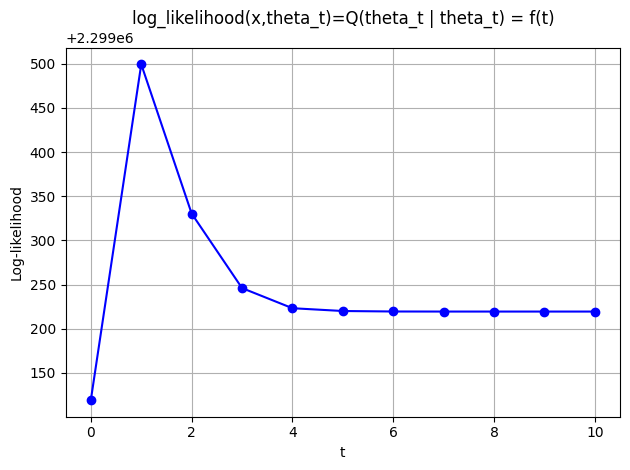

In [5]:
a_t = np.array([0.5,0.5])
mu_t = np.random.randn(2)
Sigma_t = np.array([2,3])


mu_final, Sigma_final, pi_final, log_likelihoods = run_em(X, mu_t, Sigma_t, a_t, nb_iter=100)
print("Final mu:\n", mu_final)
print("Final Sigma:\n", Sigma_final)
print("Final weights:\n", pi_final)

plt.plot(log_likelihoods, marker='o', linestyle='-', color='b')
plt.title('log_likelihood(x,theta_t)=Q(theta_t | theta_t) = f(t)')
plt.xlabel('t')
plt.ylabel('Log-likelihood')
plt.grid(True)

plt.tight_layout()
plt.show()

Observations faites (en ayant testé plein de fois l'algorithme):
* Attention : si les données sont trop étalées, il y a un vrai risque pour que la densité de certaines gaussiennes s'annule en certains points isolés. Dans le calcul du log de la log vraisemblance, cela génère ensuite un Nan...
* Si l'initialisation est trop loin du résultat, l'algo ne fonctionne pas toujours
* En général l'algo fonctionne bien pour 2 ou 3 gaussiennes mais c'est plus laborieux au delà
* Parfois, la log_vraisemblance décroît alors que le cours nous dit qu'elle n'est pas censée décroître. A quoi est-ce lié ? L'erreur liée à l'approximation des espérances par un nombre fini de points ? Des problèmes de calcul numérique ?